Entrega de trabalho final da disciplina de Machine Learning.
Turma 9DTS.

In [2]:
"""
Importando dependências
"""

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("housing.csv", delimiter=",", encoding='utf-8')

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
"""
Analisando a existencia de valores nulos
"""
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [11]:
"""
Preenchendo valores nulos com a mediana
"""

df['total_bedrooms'] = df['total_bedrooms'].fillna(df['total_bedrooms'].median())
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Análise de dados para criação do modelo

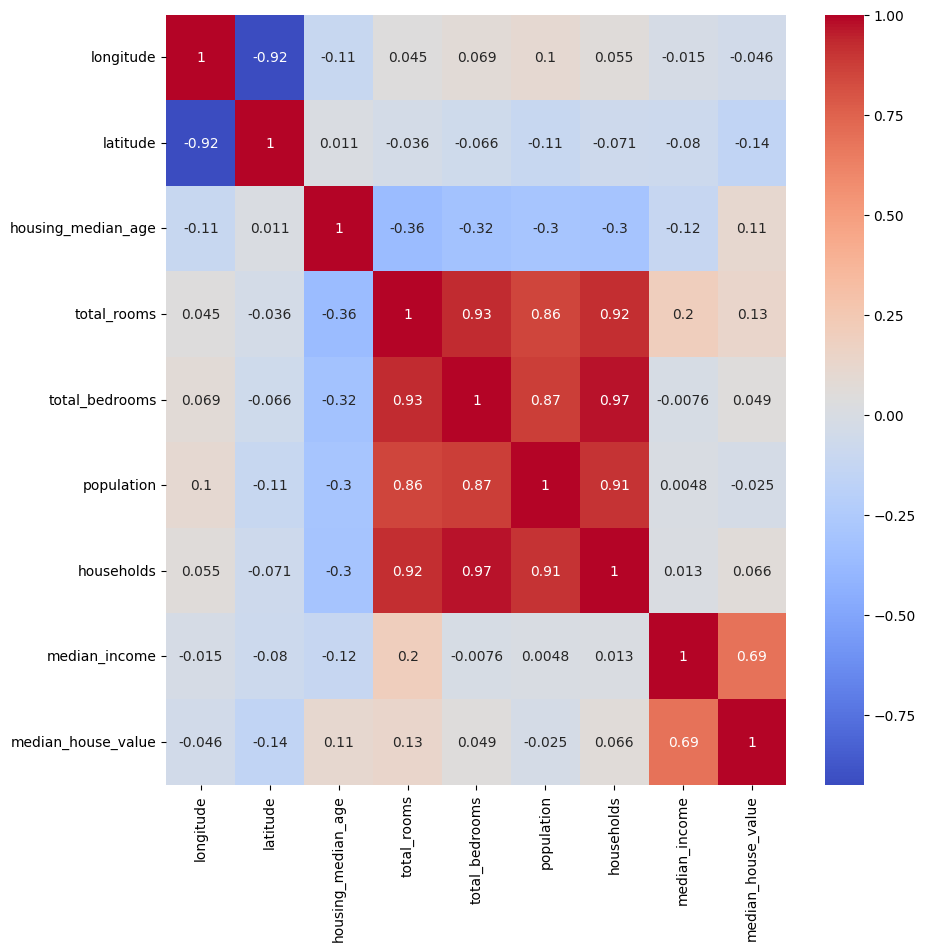

In [16]:
"""
Gerando matriz de correlação
"""
corr = df.select_dtypes(exclude='object').corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()


Separação de variáveis target e variáveis de treino.

In [23]:
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

Tratativas de base X

In [24]:
"""
Gerando dummies para dados categoricos (Ocean Proximity)
"""

dummies = pd.get_dummies(X['ocean_proximity'], drop_first=True)
X.drop('ocean_proximity', axis=1, inplace=True)

X = pd.concat([X,dummies],axis=1)
X.rename(columns={'INLAND': 'ocean_inland','ISLAND': 'ocean_island','NEAR BAY': 'ocean_nearbay','NEAR OCEAN': 'ocean_nearocean'}, inplace=True)

X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_inland,ocean_island,ocean_nearbay,ocean_nearocean
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,False,False,True,False
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,False,False,True,False
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,False,False,True,False
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,False,False,True,False
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,True,False,False,False
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,True,False,False,False
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,True,False,False,False
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,True,False,False,False


Criando base de treino e teste

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Aqui iremos setar uma função para definição de qual é o melhor modelo e quais são os melhores hiperparâmetros para o modelo.

Explicação das variáveis.

***parametros***: É um dicionário que contém os hiperparâmetros que serão testados durante o processo de busca em grade. Cada chave representa o nome de um hiperparâmetro e cada valor é uma lista com os valores possíveis para aquele hiperparâmetro.

***modelo***: É o modelo de aprendizado de máquina que será ajustado. Pode ser qualquer algoritmo de ML compatível com a biblioteca scikit-learn, como RandomForest, SVM, LogisticRegression, XGBoost entre outros.

***n_cv***: Este parâmetro define o número de divisões (ou folds) a serem usadas na validação cruzada. A validação cruzada é um método de avaliação que separa o conjunto de dados em várias partes para avaliar a capacidade do modelo de generalizar.

***type_scoring***: É a métrica de avaliação usada para escolher os melhores hiperparâmetros. Exemplos comuns incluem 'accuracy', 'f1', 'roc_auc', etc., dependendo do objetivo do modelo.

In [26]:
def grid_search(X_train, y_train, X_test, y_test, parametros, modelo, n_cv, type_scoring):
    """
    Esta função irá criar os melhores parâmetros para o modelo
    """
    #Realizar a busca pela melhor scoring definido
    grid_search = GridSearchCV(modelo, parametros, cv=n_cv, scoring=type_scoring)
    grid_search.fit(X_train, y_train)

    #Melhores hiperparâmetros encontrados
    best_params = grid_search.best_params_
    print(f"Modelo: {type(modelo).__name__}. Hiperparâmetros encontrados: {best_params}" )

    #Treinando o modelo com os melhores hiperparâmetros
    mdl = modelo.set_params(**best_params)
    mdl.fit(X_train, y_train)

    #Realizando previsões no conjunto de teste
    y_pred = mdl.predict(X_test)

    #Calcular RMSE
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    return grid_search.best_estimator_, rmse

In [27]:
#Criando os objetos
rfr = RandomForestRegressor()
xgb = XGBRegressor()
lgb = LGBMRegressor()

#Parametros que os modelos possuem em comum
parametros = {
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [None, 5, 10, 20]
}

#Realizando os calculos de Grid com os modelos
modelo_rfr, rmse_rfr = grid_search(X_train, y_train, X_test, y_test, parametros, rfr, 5, "neg_root_mean_squared_error")

modelo_xgb, rmse_xgb = grid_search(X_train, y_train, X_test, y_test, parametros, xgb, 5, "neg_root_mean_squared_error")

modelo_lgb, rmse_lgb = grid_search(X_train, y_train, X_test, y_test, parametros, lgb, 5, "neg_root_mean_squared_error")

print("")
print(f"Random Forest RMSE: {rmse_rfr:,.2f}")
print(f"XGBoost RMSE: {rmse_xgb:,.2f}")
print(f"LightGBM RMSE: {rmse_lgb:,.2f}")

mdl = modelo_rfr
rmse = rmse_rfr

#Verificando e exibindo o melhor modelo
if rmse_rfr > rmse_xgb:
  if rmse_xgb > rmse_lgb:
    mdl = modelo_lgb
    rmse = rmse_lgb
  else:
    mdl = modelo_xgb
    rmse = rmse_xgb
elif rmse_rfr > rmse_lgb:
  mdl = modelo_lgb
  rmse = rmse_lgb

print("")
print(f"O melhor modelo foi o {type(mdl).__name__}")
print(f"Os hiperparâmmetros utilizados {mdl.get_params()}")
print(f"O valor de RMSE {rmse:,.2f}")


Modelo: RandomForestRegressor. Hiperparâmetros encontrados: {'max_depth': None, 'n_estimators': 400}
Modelo: XGBRegressor. Hiperparâmetros encontrados: {'max_depth': 5, 'n_estimators': 400}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1844
[LightGBM] [Info] Number of data points in the train set: 13209, number of used features: 11
[LightGBM] [Info] Start training from score 206743.221289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1843
[LightGBM] [Info] Number of data points in the train set: 13209, number of used features: 11
[LightGBM] [Info] Start training from score 207099.730033
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set 